In [80]:
# Traffic Campaign - Objective-based Modeling Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge, LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os


In [81]:
# 2. Load Data
df = pd.read_csv('../data/meta_ads_cleaned.csv')
df = df[df['Objective'] == 'Traffic'].copy()

In [82]:
df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
14,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Instagram,Desktop,Feed,Traffic,actions:link_click,4505.81,Using ad set budget,4505.81,...,2.114411,243,71647.6,18.542428,3468,1788.29,1.299253,5850,0.770224,1501.936667
18,SO/2025/0206 Orange - Lancement posts digitaux...,active,Audience Network,Desktop,"Native, banner & interstitial",Traffic,actions:link_click,475.32,Using ad set budget,475.32,...,2.353069,111,249.0,4.282162,802,0.00,0.592668,13547,0.035087,475.320000
22,SO/2024/0582 - Orange - Campagne achat et rech...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,577.18,Using ad set budget,577.18,...,0.000000,14,0.0,41.227143,427,0.00,1.351710,2759,0.209199,577.180000
40,SO/2023/0333 - Orange - Campagne caravane Bal...,not_delivering,Facebook,In-app,Facebook Reels,Traffic,actions:link_click,368.26,Using ad set budget,368.26,...,0.000000,3,755.1,122.753333,23,0.00,16.011304,2,184.130000,0.000000
48,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,3006.70,Using ad set budget,3006.70,...,0.873279,1023,59950.0,2.939101,8444,277.50,0.356075,160516,0.018731,150.335000


In [83]:
# 3. Initial Cleanup
columns_to_drop = [
    "Campaign name", "Campaign Delivery", "Objective", "Result indicator",
    "Attribution setting", "Date created", "Starts", "Ends"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [84]:
# 4. Select relevant numeric KPIs for traffic objective
features_to_check = [
    "Amount spent", "Reach", "Impressions", "Clicks (all)",
    "CTR (all)", "CPC (all) (USD)",
    "Landing page views", "Cost per landing page view (USD)",
    "Link clicks", "Unique link clicks", "Unique CTR (link click-through rate)",
    "Unique clicks (all)", "Unique CTR (all)",
    "CPC (cost per link click) (USD)", "CTR (link click-through rate)"
]


In [85]:
# 5. Drop NA
X_raw = df[features_to_check].dropna()

In [86]:
# 6. Log1p transformation
df_log = X_raw.apply(np.log1p)
log_skew = df_log.skew()

In [87]:
# 7. PowerTransformer (Yeo-Johnson)
power = PowerTransformer(method='yeo-johnson')
df_power = pd.DataFrame(
    power.fit_transform(X_raw),
    columns=X_raw.columns
)
power_skew = df_power.skew()

In [88]:
# 8. Compare Skewness
comparison = pd.DataFrame({
    'Original': X_raw.skew(),
    'Log1p': log_skew,
    'Yeo-Johnson': power_skew
})

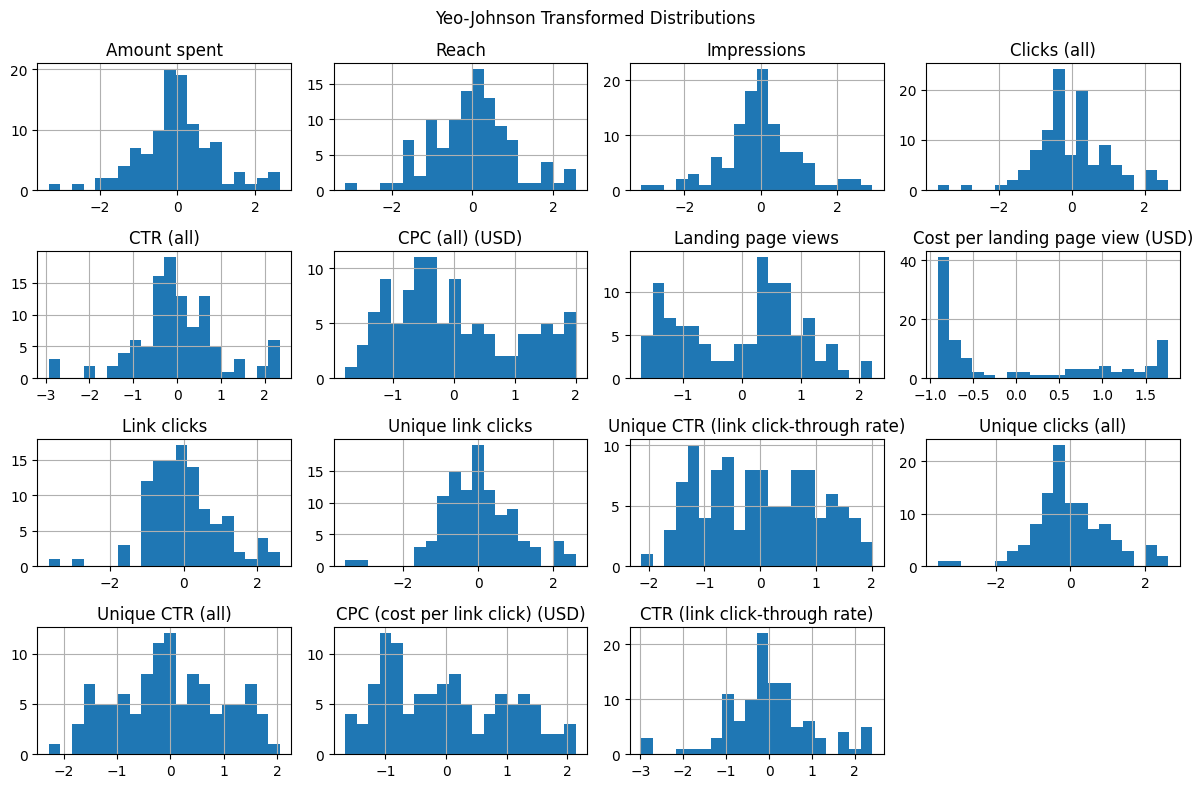

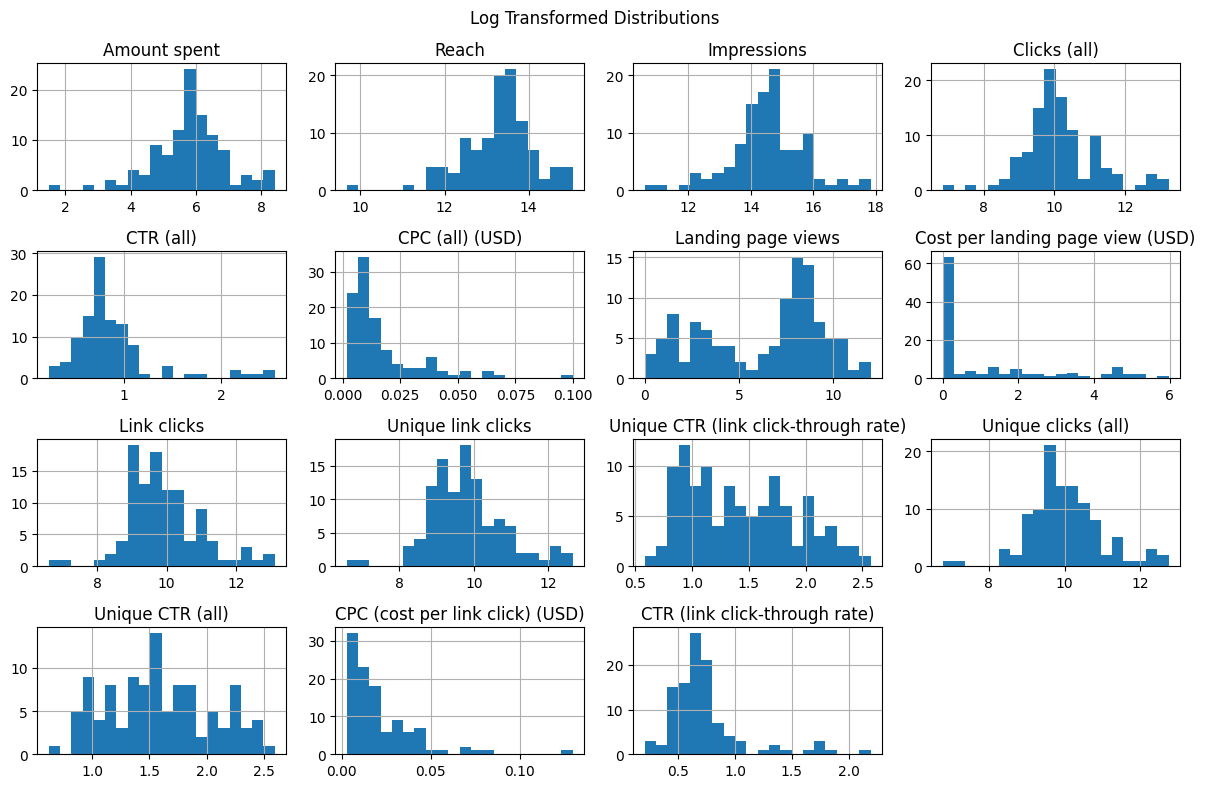

In [89]:
# 10. Visual check
df_power.hist(bins=20, figsize=(12, 8))
plt.suptitle("Yeo-Johnson Transformed Distributions")
plt.tight_layout()
plt.show()

df_log.hist(bins=20, figsize=(12, 8))
plt.suptitle("Log Transformed Distributions")
plt.tight_layout()
plt.show()

In [90]:
# 9. Save transformer
os.makedirs("models", exist_ok=True)
joblib.dump(power, "models/traffic_power_transformer.joblib")

['models/traffic_power_transformer.joblib']

In [91]:
# 11. Modeling Setup
target_cols = ["CTR (all)", "Link clicks"]
feature_cols = df_power.columns.difference(target_cols)

X = df_power[feature_cols].copy()
y = df_power[target_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# 12. Define models
models = {
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Ridge Regression": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge())
}


In [98]:
# 13. Train and evaluate
best_model = None
best_score = -np.inf
metrics_summary = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse_ctr = np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred[:, 0]))
    r2_ctr = r2_score(y_test.iloc[:, 0], y_pred[:, 0])
    mae_ctr = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])

    rmse_clicks = np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred[:, 1]))
    r2_clicks = r2_score(y_test.iloc[:, 1], y_pred[:, 1])
    mae_clicks = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])

    print(f"{name}")
    print(f"CTR - RMSE: {rmse_ctr:.4f} | MAE: {mae_ctr:.4f} | R²: {r2_ctr:.4f}")
    print(f"Link Clicks - RMSE: {rmse_clicks:.4f} | MAE: {mae_clicks:.4f} | R²: {r2_clicks:.4f}")
    print("-" * 50)

    metrics_summary.append({
        "Model": name,
        "CTR RMSE": rmse_ctr,
        "CTR MAE": mae_ctr,
        "CTR R2": r2_ctr,
        "Clicks RMSE": rmse_clicks,
        "Clicks MAE": mae_clicks,
        "Clicks R2": r2_clicks
    })

    if r2_ctr + r2_clicks > best_score:
        best_score = r2_ctr + r2_clicks
        best_model = model
        best_name = name


Linear Regression
CTR - RMSE: 0.1444 | MAE: 0.0987 | R²: 0.9848
Link Clicks - RMSE: 0.0280 | MAE: 0.0233 | R²: 0.9994
--------------------------------------------------
Ridge Regression
CTR - RMSE: 0.1684 | MAE: 0.1258 | R²: 0.9794
Link Clicks - RMSE: 0.0694 | MAE: 0.0423 | R²: 0.9962
--------------------------------------------------
Random Forest
CTR - RMSE: 0.2946 | MAE: 0.2423 | R²: 0.9368
Link Clicks - RMSE: 0.1676 | MAE: 0.0999 | R²: 0.9779
--------------------------------------------------
Bayesian Ridge
CTR - RMSE: 0.1534 | MAE: 0.1077 | R²: 0.9829
Link Clicks - RMSE: 0.0247 | MAE: 0.0205 | R²: 0.9995
--------------------------------------------------


In [99]:
# Convert summary to DataFrame
metrics_df = pd.DataFrame(metrics_summary)

In [100]:
# 14. Cross-validation on best model
cv_r2 = cross_val_score(best_model, X, y, scoring='r2', cv=5)
cv_mse = -cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5)
cv_mae = -cross_val_score(best_model, X, y, scoring='neg_mean_absolute_error', cv=5)

print(f"\n📊 Cross-Validation ({best_name})")
print(f"Avg R²: {np.mean(cv_r2):.4f}")
print(f"Avg RMSE: {np.mean(np.sqrt(cv_mse)):.4f}")
print(f"Avg MAE: {np.mean(cv_mae):.4f}")


📊 Cross-Validation (Linear Regression)
Avg R²: 0.9918
Avg RMSE: 0.0852
Avg MAE: 0.0524


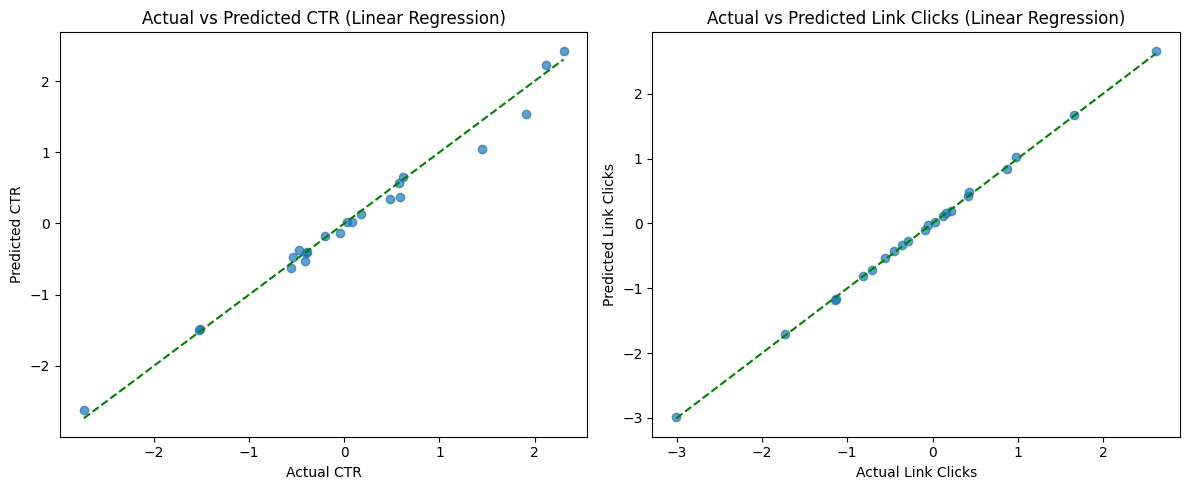

In [101]:
# 15. Plot actual vs predicted for best model
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test.iloc[:, 0], y_pred_best[:, 0], alpha=0.7)
plt.plot([y_test['CTR (all)'].min(), y_test['CTR (all)'].max()],
         [y_test['CTR (all)'].min(), y_test['CTR (all)'].max()], '--g')
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")
plt.title(f"Actual vs Predicted CTR ({best_name})")

plt.subplot(1, 2, 2)
plt.scatter(y_test.iloc[:, 1], y_pred_best[:, 1], alpha=0.7)
plt.plot([y_test['Link clicks'].min(), y_test['Link clicks'].max()],
         [y_test['Link clicks'].min(), y_test['Link clicks'].max()], '--g')
plt.xlabel("Actual Link Clicks")
plt.ylabel("Predicted Link Clicks")
plt.title(f"Actual vs Predicted Link Clicks ({best_name})")

plt.tight_layout()
plt.show()

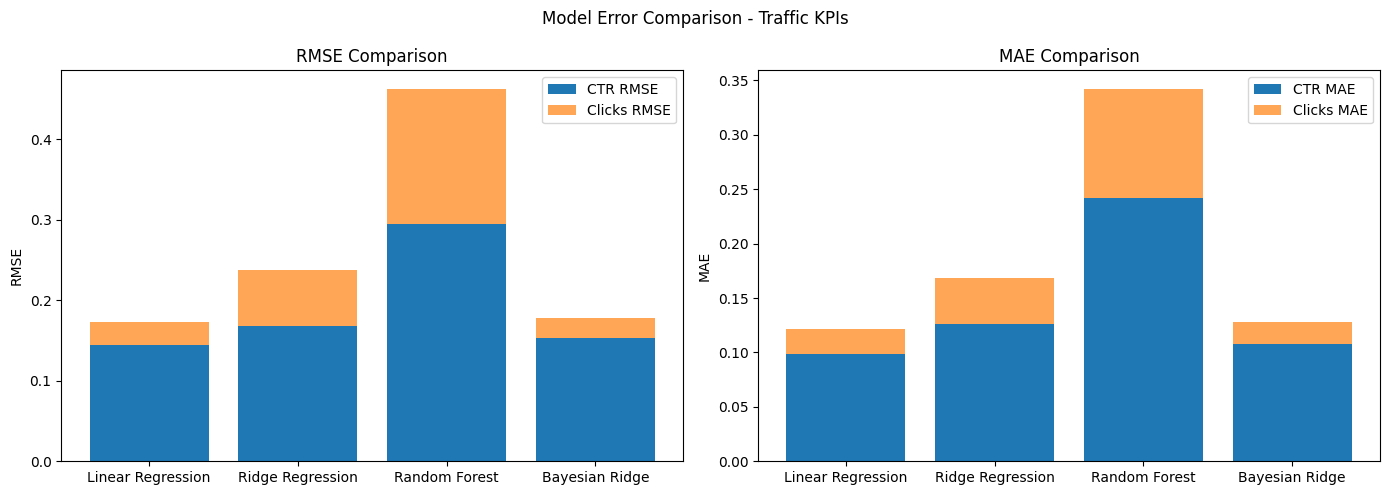

In [102]:
# 16. Visualize RMSE and MAE for all models
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].bar(metrics_df['Model'], metrics_df['CTR RMSE'], label='CTR RMSE')
axs[0].bar(metrics_df['Model'], metrics_df['Clicks RMSE'], bottom=metrics_df['CTR RMSE'], label='Clicks RMSE', alpha=0.7)
axs[0].set_title('RMSE Comparison')
axs[0].legend()
axs[0].set_ylabel("RMSE")

axs[1].bar(metrics_df['Model'], metrics_df['CTR MAE'], label='CTR MAE')
axs[1].bar(metrics_df['Model'], metrics_df['Clicks MAE'], bottom=metrics_df['CTR MAE'], label='Clicks MAE', alpha=0.7)
axs[1].set_title('MAE Comparison')
axs[1].legend()
axs[1].set_ylabel("MAE")

plt.suptitle("Model Error Comparison - Traffic KPIs")
plt.tight_layout()
plt.show()


In [105]:
# 17. Save best model
joblib.dump(best_model, f"models/{best_name.lower().replace(' ', '_')}_traffic_model.joblib")
joblib.dump(list(feature_cols), "models/traffic_model_features.pkl")

['models/traffic_model_features.pkl']

In [108]:
print(f"""
Traffic Campaign Modeling Summary (Incl. Bayesian + CV + Visuals)

We tested 4 models to predict CTR and Link Clicks.

🔹Best Model: {best_name}

📈 CV Avg R²: {np.mean(cv_r2):.4f} | RMSE: {np.mean(np.sqrt(cv_mse)):.4f} | MAE: {np.mean(cv_mae):.4f}
📦 Saved as: `{best_name.lower().replace(' ', '_')}_traffic_model.joblib`
📁 Features: `traffic_model_features.pkl`

Visual and numerical validation confirm prediction quality.
""")


Traffic Campaign Modeling Summary (Incl. Bayesian + CV + Visuals)

We tested 4 models to predict CTR and Link Clicks.

🔹Best Model: Linear Regression

📈 CV Avg R²: 0.9918 | RMSE: 0.0852 | MAE: 0.0524
📦 Saved as: `linear_regression_traffic_model.joblib`
📁 Features: `traffic_model_features.pkl`

Visual and numerical validation confirm prediction quality.

